# Solution: Applying Stereo Depth to a Driving Scenario

This is the solution file for the practice notebook.  You are recommended to use OpenCV documentation for solving the assignment and refer to the solution only after you finish this practice exercise.  

By the end of this exercise, you will be abl

- Be able to use OpenCV to complete standard vision tasks.
- Understand the process of obtaining depth from a pair of stereo images and their respective projection matrices.
- Understand the advantages of cross-correlation for localization of important information in an image.

Let's go!

## 1 - Getting Set-up

First, let's run the cell below to import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [cv2] (https://opencv.org) is the most used library for computer vision applications in Python. 
- The `files_management` package contains pre-developed functions for importing data for the assignment.

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import patches

%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision %.2f

import files_management

Now, let's get the pair of stereo images you will work with. The following code will load the images and then display them for you.

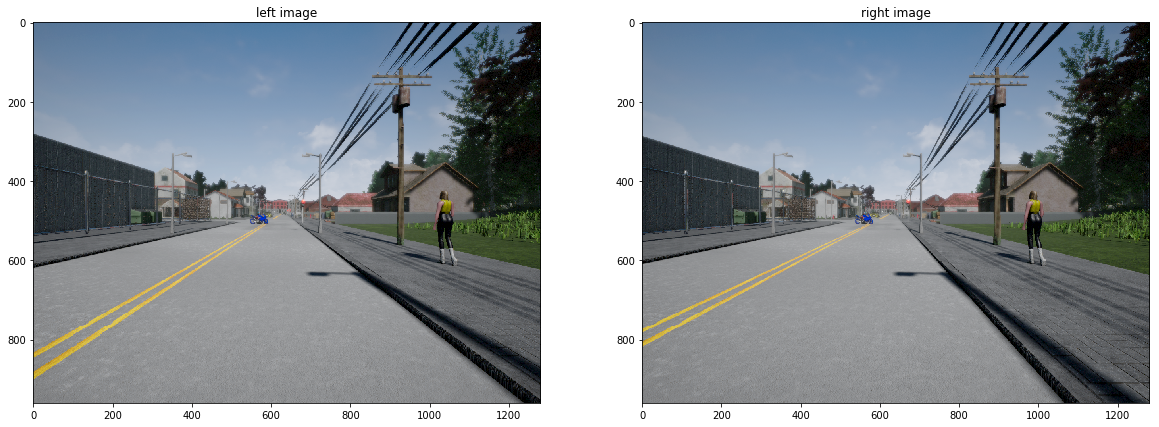

In [2]:
# Read the stereo-pair of images
img_left = files_management.read_left_image()
img_right = files_management.read_right_image()

# Use matplotlib to display the two images
_, image_cells = plt.subplots(1, 2, figsize=(20, 20))
image_cells[0].imshow(img_left)
image_cells[0].set_title('left image')
image_cells[1].imshow(img_right)
image_cells[1].set_title('right image')
plt.show()

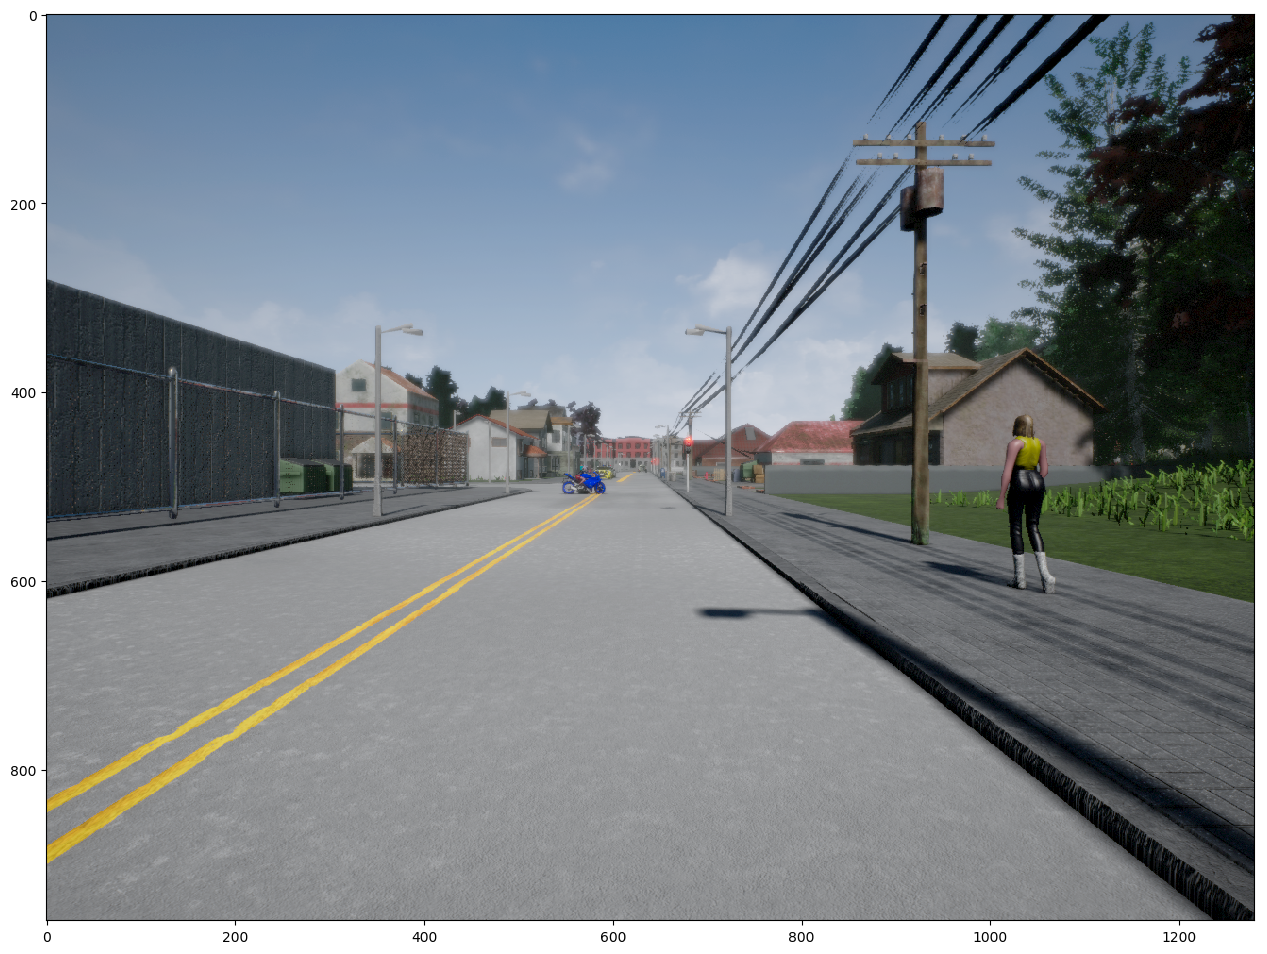

In [3]:
# Large plot of the left image
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(img_left)

To go with these images are their respective projection matrices. Let's run the following to gather these and print them. 

In [4]:
# Read the calibration
p_left, p_right = files_management.get_projection_matrices()

# Use regular numpy notation instead of scientific one 
np.set_printoptions(suppress=True)

print("p_left \n", p_left)
print("\np_right \n", p_right)

p_left 
 [[ 640.     0.   640.  2176. ]
 [   0.   480.   480.   552. ]
 [   0.     0.     1.     1.4]]

p_right 
 [[ 640.     0.   640.  2176. ]
 [   0.   480.   480.   792. ]
 [   0.     0.     1.     1.4]]


With this information we can move into finding the depth of the scene.

## 2 - Estimating Depth

As we covered in Module 1 Lesson 3 Part 1, we can estimate the depth of a stereo scene using the following sequence of actions:
1. Determine the disparity between the two images.
2. Decompose the projection matrices into the camera intrinsic matrix $K$, and extrinsics $R$, $t$.
3. Estimate depth using what we've gathered in the two prior steps.

### 2.1 - Computing the Disparity

It's time we began exploring some OpenCV functions. The following `compute_left_disparity_map` function is expected to recieve a stereo pair of images and return a disparity map from the perspective of the left camera. 

There are two OpenCV functions that we can use to compute a disparity map [StereoBM](https://docs.opencv.org/3.4.3/d9/dba/classcv_1_1StereoBM.html) and [StereoSGBM](https://docs.opencv.org/3.4.3/d2/d85/classcv_1_1StereoSGBM.html). 

Once you've chosen the matcher to use you can call `matcher.compute(img_left, img_right)` to generate the disparity output.

**Note**: make sure you are using grayscale images for the `matcher.compute()` method. Refer to the OpenCV documentation for more information

In [5]:
def compute_left_disparity_map(img_left, img_right):
    
    ### START CODE HERE ###
    
    # Parameters
    num_disparities = 6*16
    block_size = 11
    
    min_disparity = 0
    window_size = 6
    
    img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    
    # Stereo BM matcher
    left_matcher_BM = cv2.StereoBM_create(
        numDisparities=num_disparities,
        blockSize=block_size
    )

    # Stereo SGBM matcher
    left_matcher_SGBM = cv2.StereoSGBM_create(
        minDisparity=min_disparity,
        numDisparities=num_disparities,
        blockSize=block_size,
        P1=8 * 3 * window_size ** 2,
        P2=32 * 3 * window_size ** 2,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )

    # Compute the left disparity map
    disp_left = left_matcher_SGBM.compute(img_left, img_right).astype(np.float32)/16
    
    ### END CODE HERE ###
    
    return disp_left

In order to get an idea of how the parameters and choice of matcher change the resulting disparity map you can run the following code to visualize it.

As you will find while you continue in this course, your choices in paramters will have to vary to fit the data being provided. Take some time to experiment with different combinations, and both of the matchers to see which best fits the images you have been provided.

Don't forget to read about the functions and the restrictions on the paramters.

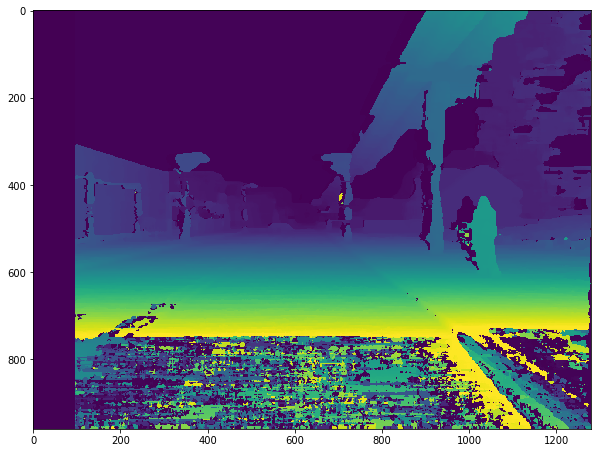

In [6]:
# Compute the disparity map using the fuction above
disp_left = compute_left_disparity_map(img_left, img_right)

# Show the left disparity map
plt.figure(figsize=(10, 10))
plt.imshow(disp_left)
plt.show()

### 2.2 - Decompose the projection matrices

In Lesson 2 we touched on how to decompose a projection matrix $P$: 
1. Represent $P$ as a combination of the intrinsic parameters $K$ and the extrinsic rotation $R$ and translation $t$ as follows: 
$$ $$
$$P = K[R|t]$$
$$ $$
2. Take the inverse of $KR$, which allows us to perform QR-decomposition to get $R^{-1}$ and $K^{-1}$: 
$$ $$
$$(KR)^{-1} = R^{-1}K^{-1}$$
$$ $$
3. From here it would seem as though we could easily determine $K$, $R$, and $t$.

Unfortunately, this isn't as simple as it seems due to the QR-decomposition isn't unique. This results in us having to check the signs of the diagonal of the $K$ matrix and adjust $R$ appropriately. We must also make assertions about the directions of our camera and image x, y, and z axes.

Luckily for us, OpenCV provides us with a single function that does all of this. Using cv2.[decomposeProjectionMatrix()](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html#gaaae5a7899faa1ffdf268cd9088940248). Use this function below to extract the required matrices.


**Note**: After carrying out the matrix multiplication, the homogeneous component $w_c$ will, in general, not be equal to 1. Therefore, to map back into the real plane we must perform the homogeneous divide or perspective divide by dividing each component by $w_c$



#### Optional
You can optionally use the space in the function below to try your hand at finding $K$, $R$, and $t$ manually. The numpy functions `np.linalg.inv()`, `np.linalg.qr()`, and `np.matmul()` would be of help in this case. 
You can use the following code block to compare your resulting $K$, $R$, and $t$ with those returned by the OpenCV function.

In [7]:
def decompose_projection_matrix(p):
    
    ### START CODE HERE ###
    
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = t / t[3]
    
    ### END CODE HERE ###
    
    return k, r, t

The following code section uses your function above to decompose and print all of the matrices from the left and right projection matrices.

In [8]:
# Decompose each matrix
k_left, r_left, t_left = decompose_projection_matrix(p_left)
k_right, r_right, t_right = decompose_projection_matrix(p_right)

# Display the matrices
print("k_left \n", k_left)
print("\nr_left \n", r_left)
print("\nt_left \n", t_left)
print("\nk_right \n", k_right)
print("\nr_right \n", r_right)
print("\nt_right \n", t_right)

k_left 
 [[640.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]

r_left 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t_left 
 [[-2.  ]
 [ 0.25]
 [-1.4 ]
 [ 1.  ]]

k_right 
 [[640.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]

r_right 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t_right 
 [[-2.  ]
 [-0.25]
 [-1.4 ]
 [ 1.  ]]


### 2.3 - Generate the depth map

Lesson 3 explains how to derive the depth from a pair of images taken with a stereo camera setup. Recall the sequence of this procedure: 

1. Get the focal length $f$ from the $K$ matrix
2. Compute the baseline $b$ using corresponding values from the translation vectors $t$
3. Compute depth map of the image: $$Z = \frac{f b}{x_L - x_R} = \frac{f b}{d}$$ In the above equation, $d$ is a disparity map which we have already computed in one of the previous steps in this assignment.

**Your task**: Complete the `calc_depth_map` function below to return a depth map of the same dimensions as the disparity map being provided. 

**Note:** Don't forget to address problematic disparities (the ones having of 0 and -1) to eliminate potential computational issues.

In [9]:
def calc_depth_map(disp_left, k_left, t_left, t_right):

    ### START CODE HERE ###
    
    # Get the focal length from the K matrix
    f = k_left[0, 0]

    # Get the distance between the cameras from the t matrices (baseline)
    b = t_left[1] - t_right[1]

    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disp_left[disp_left == 0] = 0.1
    disp_left[disp_left == -1] = 0.1

    # Initialize the depth map to match the size of the disparity map
    depth_map = np.ones(disp_left.shape, np.single)

    # Calculate the depths 
    depth_map[:] = f * b / disp_left[:]
    
    ### END CODE HERE ###
    
    return depth_map

Below we call the calc_depth_map function to generate a depth map for the disparity map we found in 2.1.

The depth map is displayed for reference.

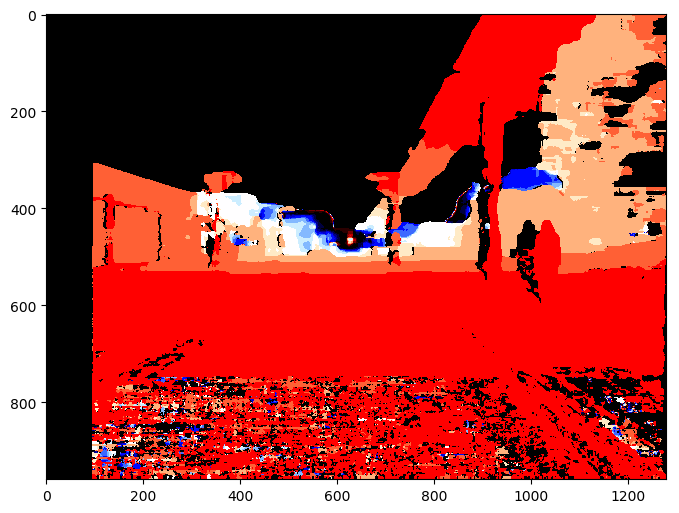

In [10]:
# Get the depth map by calling the above function
depth_map_left = calc_depth_map(disp_left, k_left, t_left, t_right)

# Display the depth map
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(depth_map_left, cmap='flag')
plt.show()

Excellent! Now you have successfully used a stereo pair of images to determine the depth of a scene! 

## 3 - Finding the distance to collision

While we may have a map of the depths of each pixel in the scene, our system does not yet know which of these pixels are safe (like the road) or a potential obstacle (like a motorcycle). To find these objects of interest we run an object detector that has been trained to select a rectangular section containing the object we are concerned about. Object detection will be covered in future modules, so for now we will just work with the motorcycle image that was identified by the detector.

Run the following section of code to read the motorcycle image and display it.

In [1]:
# Get the image of the obstacle
obstacle_image = files_management.get_obstacle_image()

# Show the obstacle image
plt.figure(figsize=(4, 4))
plt.imshow(obstacle_image)
plt.show()

NameError: name 'files_management' is not defined

What we would like to do now is have the system automatically determine where this obstacle is in the scene. For this we will use cross correlation as described in Lesson 4. As described in the lesson, the algorithm behind cross correlation requires us to perform large numerical computations at each pixel in the image. 
However, once again we are saved by OpenCV. Using the cv2.[matchTemplate()](https://docs.opencv.org/3.4.3/df/dfb/group__imgproc__object.html#ga586ebfb0a7fb604b35a23d85391329be) function we can quickly and easily complete the cross correlation of the obstacle template. From this heatmap we can use the cv2.[minMaxLoc()](https://docs.opencv.org/3.4.3/d2/de8/group__core__array.html#ga8873b86a29c5af51cafdcee82f8150a7) function to extract the position of the obstacle.
minMaxLoc
Implement these two functions in the below section to extract the cross correlation heatmat and the corresponding point of the obstacle.

#### Optional:
Again, if you'd like to challenge yourself you can instead implement the cross correlation algorithm manually in the function below.

In [12]:
def locate_obstacle_in_image(image, obstacle_image):
    
    ### START CODE HERE ###
    
    # Run the template matching from OpenCV
    cross_corr_map = cv2.matchTemplate(image, obstacle_image, method=cv2.TM_CCOEFF)
    
    # Locate the position of the obstacle using the minMaxLoc function from OpenCV
    _, _, _, obstacle_location = cv2.minMaxLoc(cross_corr_map)

    ### END CODE HERE ###

    return cross_corr_map, obstacle_location

Running the following code section will call your above function and then display the resulting cross correlation heatmap and obstacle location coordinates.

You may take this opportunity to try different "methods" for the matchTemplate function. 

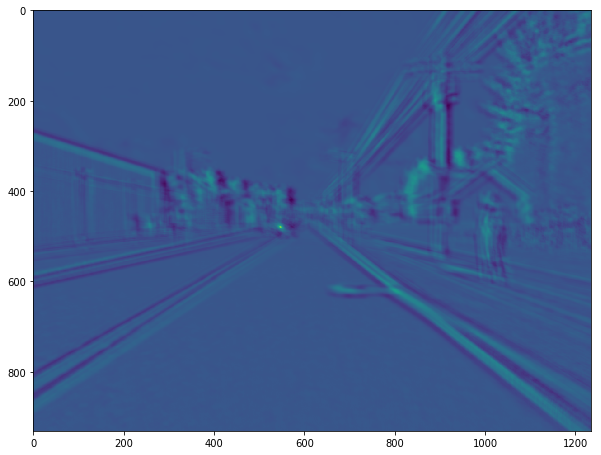

obstacle_location 
 (547, 479)


In [13]:
# Gather the cross correlation map and the obstacle location in the image
cross_corr_map, obstacle_location = locate_obstacle_in_image(img_left, obstacle_image)

# Display the cross correlation heatmap 
plt.figure(figsize=(10, 10))
plt.imshow(cross_corr_map)
plt.show()

# Print the obstacle location
print("obstacle_location \n", obstacle_location)

One final step to go! All that's left to do is to crop the section of the depth map that corresponds to the obstacle and find the nearest point in that crop.

Complete the function below to return the obstacle's bounding box and the distance to the nearest point within that bounding box.

In [14]:
def calculate_nearest_point(depth_map, obstacle_location, obstacle_img):
    
    ### START CODE HERE ###
    
    # Gather the relative parameters of the obstacle box
    obstacle_width = obstacle_img.shape[0]
    obstacle_height = obstacle_img.shape[1]
    obstacle_min_x_pos = obstacle_location[1]
    obstacle_max_x_pos = obstacle_location[1] + obstacle_width
    obstacle_min_y_pos = obstacle_location[0]
    obstacle_max_y_pos = obstacle_location[0] + obstacle_height

    # Get the depth of the pixels within the bounds of the obstacle image, find the closest point in this rectangle
    obstacle_depth = depth_map_left[obstacle_min_x_pos:obstacle_max_x_pos, obstacle_min_y_pos:obstacle_max_y_pos]
    closest_point_depth = obstacle_depth.min()

    ### END CODE HERE ###
    
    # Create the obstacle bounding box 
    obstacle_bbox = patches.Rectangle((obstacle_min_y_pos, obstacle_min_x_pos), obstacle_height, obstacle_width, 
                                 linewidth=1, edgecolor='r', facecolor='none')
    
    return closest_point_depth, obstacle_bbox

At this point you should know where the obstacle is in the image as well as the estimated nearest point of the obstacle.

Run the section of code below to visualize the bounding box and the depth of the nearest point.

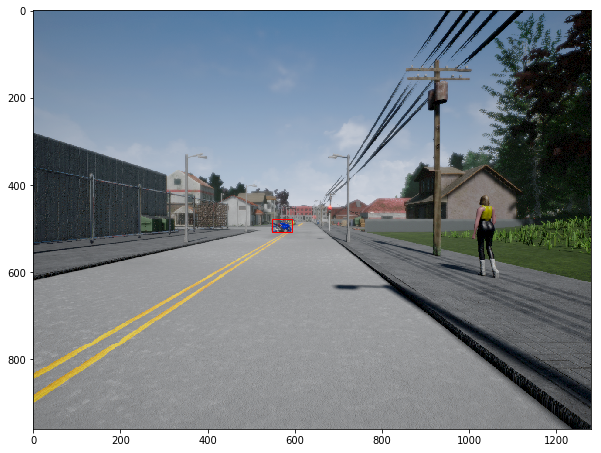

closest_point_depth 28.927


In [15]:
# Use the developed nearest point function to get the closest point depth and obstacle bounding box
closest_point_depth, obstacle_bbox = calculate_nearest_point(depth_map_left, obstacle_location, obstacle_image)

# Display the image with the bounding box displayed
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img_left)
ax.add_patch(obstacle_bbox)
plt.show()

# Print the depth of the nearest point
print("closest_point_depth {0:0.3f}".format(closest_point_depth))

## 4 - Results:

To summurize your work on this assignment we will have a look at three outputs for frame 1 of the dataset:

1. The decomposed components of left and right projection matrices from part 2.
2. The estimated obstacle location from part 2.
3. The estimated closest point depth from part 2. 

**Expected Result Output**:

```
Left Projection Matrix Decomposition:
 [[left camera calibration matrix], [left camera rotation matrix], [left camera translation vector]]

Right Projection Matrix Decomposition:
  [[right camera calibration matrix], [right camera rotation matrix], [right camera translation vector]]

Obstacle Location (left-top corner coordinates):
 [x, y]

Closest point depth (meters):
 d
```

In [16]:
# Part 1. Read Input Data
img_left = files_management.read_left_image()
img_right = files_management.read_right_image()
p_left, p_right = files_management.get_projection_matrices()


# Part 2. Estimating Depth
disp_left = compute_left_disparity_map(img_left, img_right)
k_left, r_left, t_left = decompose_projection_matrix(p_left)
k_right, r_right, t_right = decompose_projection_matrix(p_right)
depth_map_left = calc_depth_map(disp_left, k_left, t_left, t_right)


# Part 3. Finding the distance to collision
obstacle_image = files_management.get_obstacle_image()
cross_corr_map, obstacle_location = locate_obstacle_in_image(img_left, obstacle_image)
closest_point_depth, obstacle_bbox = calculate_nearest_point(depth_map_left, obstacle_location, obstacle_image)


# Print Result Output
print("Left Projection Matrix Decomposition:\n {0}".format([k_left.tolist(), 
                                                            r_left.tolist(), 
                                                            t_left.tolist()]))
print("\nRight Projection Matrix Decomposition:\n {0}".format([k_right.tolist(), 
                                                               r_right.tolist(), 
                                                               t_right.tolist()]))
print("\nObstacle Location (left-top corner coordinates):\n {0}".format(list(obstacle_location)))
print("\nClosest point depth (meters):\n {0}".format(closest_point_depth))

Left Projection Matrix Decomposition:
 [[[640.0, 0.0, 640.0], [0.0, 480.0, 480.0], [0.0, 0.0, 1.0]], [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], [[-1.9999999999999998], [0.24999999999999944], [-1.3999999999999997], [1.0]]]

Right Projection Matrix Decomposition:
 [[[640.0, 0.0, 640.0], [0.0, 480.0, 480.0], [0.0, 0.0, 1.0]], [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], [[-1.9999999999999998], [-0.25000000000000006], [-1.4], [1.0]]]

Obstacle Location (left-top corner coordinates):
 [547, 479]

Closest point depth (meters):
 28.92655372619629


Congrats on finishing this assignment! 